In [1]:
import sys
#sys.path.remove('/Users/evsi8432/Documents/Research/CarHHMM-DFT/Repository/Code')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d

from math import isclose

from copy import deepcopy

import importlib

import time
import pickle
import random

In [2]:
import Preprocessor
import Parameters
import HHMM
import Visualisor
import optimizor

from optimizor import eta_2_Gamma
from optimizor import Gamma_2_eta
from optimizor import logdotexp

np.random.seed(0)
random.seed(0)

# Initialize Parameters

In [3]:
# parameters for data
pars = Parameters.Parameters()
pars.features = [{'Y':{'corr':False,'f':'normal'}}, # coarse-scale
                 {}]
pars.K = [3,1]
T = 10000
experiment = 2


if experiment == 1:
    
    Gamma = np.array([[0.9,0.05,0.05],
                      [0.05,0.9,0.05],
                      [0.05,0.05,0.9]])
    delta = np.ones(pars.K[0])/pars.K[0]
    mus = np.array(range(pars.K[0])).astype("float64")
    sigs = np.exp(np.array([-1.0,1.0,0.0]))
    
elif experiment == 2:
    
    Gamma = np.array([[0.99,0.005,0.005],
                      [0.005,0.99,0.005],
                      [0.005,0.005,0.99]])
    delta = np.ones(pars.K[0])/pars.K[0]
    mus = np.array(range(pars.K[0])).astype("float64")
    sigs = np.exp(np.array([-1.0,1.0,0.0]))

    
# optimization parameters 
methods = ["SAGA","EM","BFGS","Nelder-Mead"]
# methods = ["EM","SGD","SAG","SVRG","SAGA","GD","BFGS","Nelder-Mead"]

# pick optimization settings
step_sizes = {"EM"  : [None,None],
              "Nelder-Mead": [None,None],
              "BFGS": [None,None],
              "SGD" : [0.01,0.01],
              "SAG" : [0.01,0.01],
              "SVRG": [0.01,0.01],
              "SAGA": [0.01,0.01]}

num_epochs = 50
tol = 1e-10
grad_tol = 1e-8

# Simulate Data

In [4]:
X = np.zeros(T,dtype=int)
data = []

for t in range(T):
    
    if t == 0:
        X[t] = np.random.choice(pars.K[0],p=delta)
    else:
        X[t] = np.random.choice(pars.K[0],p=Gamma[X[t-1]])

    data.append({'Y':mus[X[t]] + sigs[X[t]]*np.random.normal(),
                 'subdive_features':[]})

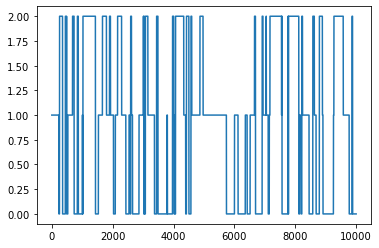

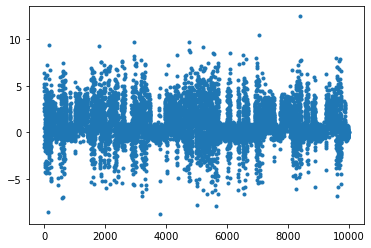

In [5]:
plt.plot(X)
plt.show()
plt.plot([x["Y"] for x in data],'.')
plt.show()

# Train the HMM

In [6]:
importlib.reload(optimizor)

# intialize HHMM
hhmm = HHMM.HHMM(pars,data)

hhmm.theta = [{'Y': {'mu': np.array([-1.0,  1.1,  2.1]),
                     'log_sig': np.array([0.0, 0.0, 0.0]),
                     'corr': np.zeros(pars.K[0])}},
               [{}, {}, {}]]

hhmm.Gamma = [Gamma,
             [np.array([[1.]]), np.array([[1.]]), np.array([[1.]])]]

hhmm.eta = Gamma_2_eta(hhmm.Gamma)

# initialize optims
optims = {}
times = {}

# get optimal value via EM:
optims["control"] = optimizor.optimizor(hhmm)
optims["control"].step_size = [None,None]
optims["control"].param_bounds["Y"]["mu"] = [-100,100]
optims["control"].param_bounds["Y"]["log_sig"] = [-5,5]

optims["control"].train_HHMM(num_epochs=num_epochs,
                                      method="EM",
                                      tol=1e-15)
optim_ll = optims["control"].log_like_trace[-1]
    
for method in methods:
    
    for partial_E in [0,0.5,1]:
        
        if partial_E > 0 and method in ["EM","BFGS","Nelder-Mead"]:
            continue
        
        print(method,partial_E)
        print("")

        optims[(method,partial_E)] = optimizor.optimizor(hhmm)
        optims[(method,partial_E)].step_size = step_sizes[method]
        optims[(method,partial_E)].param_bounds["Y"]["mu"] = [-100,100]
        optims[(method,partial_E)].param_bounds["Y"]["log_sig"] = [-5,5]
        
        if partial_E == 0:
            optims[(method,partial_E)].train_HHMM(num_epochs=num_epochs,
                                                  method=method,
                                                  max_iters=T,
                                                  partial_E=False,
                                                  alpha_theta=step_sizes[method][0],
                                                  alpha_eta=step_sizes[method][1],
                                                  tol=tol,
                                                  grad_tol=grad_tol,
                                                  record_like = True)
        elif partial_E == 0.5:
            if method in ["SGD","SAG","SVRG","SAGA"]:
                optims[(method,partial_E)].train_HHMM(num_epochs=num_epochs,
                                                      method=method,
                                                      max_iters=T,
                                                      partial_E=True,
                                                      alpha_theta=step_sizes[method][0],
                                                      alpha_eta=step_sizes[method][1],
                                                      tol=tol,
                                                      grad_tol=grad_tol,
                                                      record_like = True)
        elif partial_E == 1:
            if method in ["SGD","SAG","SVRG","SAGA"]:
                optims[(method,partial_E)].train_HHMM(num_epochs=num_epochs,
                                                      method=method,
                                                      max_iters=10*T,
                                                      partial_E=True,
                                                      alpha_theta=step_sizes[method][0],
                                                      alpha_eta=step_sizes[method][1],
                                                      tol=tol,
                                                      grad_tol=grad_tol,
                                                      record_like = True)

/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src/optimizor.py:194: RuntimeWarning:

divide by zero encountered in true_divide

/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src/optimizor.py:195: RuntimeWarning:

divide by zero encountered in true_divide

/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src/optimizor.py:209: RuntimeWarning:

divide by zero encountered in double_scalars



starting epoch 0.0

starting E-step...
...done
-24113.78564680354
starting M-step...
...done

starting epoch 0.5

starting E-step...


/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src/optimizor.py:916: RuntimeWarning:

invalid value encountered in double_scalars



...done
-19855.70558539041
starting M-step...
...done

starting epoch 1.0

starting E-step...
...done
-18912.687971129686
starting M-step...
...done

starting epoch 1.5

starting E-step...
...done
-16009.725167014682
starting M-step...
...done

starting epoch 2.0

starting E-step...
...done
-14985.370433984857
starting M-step...
...done

starting epoch 2.5

starting E-step...
...done
-14966.48411748297
starting M-step...
...done

starting epoch 3.0

starting E-step...
...done
-14965.808983554196
starting M-step...
...done

starting epoch 3.5

starting E-step...
...done
-14965.750084783864
starting M-step...
...done

starting epoch 4.0

starting E-step...
...done
-14965.744800395196
starting M-step...
...done

starting epoch 4.5

starting E-step...
...done
-14965.744329787363
starting M-step...
...done

starting epoch 5.0

starting E-step...
...done
-14965.744288010557
starting M-step...
...done

starting epoch 5.5

starting E-step...
...done
-14965.74428430589
starting M-step...
...don

...done
-14965.75949554983
starting M-step...
4.874542533032047e-05
M-step failed to converge: maximum number of iterations reached
...done

starting epoch 37.0

starting E-step...
...done
-14965.757158375847
starting M-step...
4.4760842475059115e-05
M-step failed to converge: maximum number of iterations reached
...done

starting epoch 38.0

starting E-step...
...done
-14965.75518690124
starting M-step...
4.110329067072365e-05
M-step failed to converge: maximum number of iterations reached
...done

starting epoch 39.0

starting E-step...
...done
-14965.753524577152
starting M-step...
3.7786644397515295e-05
M-step failed to converge: maximum number of iterations reached
...done

starting epoch 40.0

starting E-step...
...done
-14965.752119706047
starting M-step...
3.473449401186447e-05
M-step failed to converge: maximum number of iterations reached
...done

starting epoch 41.0

starting E-step...
...done
-14965.750932157896
starting M-step...
3.196564004042879e-05
M-step failed to conv

...done
-14965.76311635076
starting M-step...
5.499473898879254e-05
M-step failed to converge: maximum number of iterations reached
...done

starting epoch 48.0

starting E-step...
...done
-14965.760171988979
starting M-step...
5.050530097891606e-05
M-step failed to converge: maximum number of iterations reached
...done

starting epoch 49.5

starting E-step...
...done
-14965.757695232007
starting M-step...
4.6383056074312484e-05
M-step failed to converge: maximum number of iterations reached
...done

maximum number of epochs (51.0) reached. Returning...
SAGA 1

starting epoch 0.0

starting E-step...
...done
-24113.78564680354
starting M-step...
0.3307883022248337
0.1227283409675593
0.04545512438164218
0.016602160196994432
0.006798329606169748
0.003067701990780612
0.0021690230272107805
0.0020621782348920477
0.002322293428854538
0.0022653245064899637
M-step failed to converge: maximum number of iterations reached
...done

starting epoch 10.5

starting E-step...
...done
-14991.86392716564

-16383.443859170036
-16383.44386996481
-16383.443866431191
-16383.443866093094
-16383.443859064768
-16383.443858841183
-16383.443859145678
-16383.443862381919
-16383.443859767158
-16383.443857446935
-16217.40832923043
-16217.408334004615
-16217.408325969443
-16217.408329497732
-16217.408337126873
-16217.408323859048
-16217.408331863347
-16217.408329578913
-16217.408329269292
-16217.408329339532
-16217.408328647245
-16217.408329445385
-16217.408329361717
-16292.940265377205
-16292.9402722768
-16292.940264956653
-16292.940265822408
-16292.940271619627
-16292.940270509447
-16292.94027151938
-16292.940266934329
-16292.94026539189
-16292.940265325231
-16292.940267330048
-16292.940265409372
-16292.940264889752
-16204.69863167969
-16204.698637065452
-16204.69862930981
-16204.698631992274
-16204.698639103597
-16204.69862920269
-16204.698634997716
-16204.69863226729
-16204.698631708403
-16204.69863173184
-16204.698631404037
-16204.69863184162
-16204.698631716745
-16187.861792576416
-16187.86179

-15052.001242139171
-15052.001244377154
-15052.001244982055
-15052.001244516181
-15052.001247379934
-15052.001245680394
-15052.001244899191
-15052.001244995507
-15052.001244995017
-15052.001245138734
-15052.001245025207
-15052.001244914576
-15048.849440402626
-15048.849439233332
-15048.84944011595
-15048.849440360858
-15048.849440277407
-15048.849441693374
-15048.849440492142
-15048.84944034368
-15048.849440402608
-15048.849440402131
-15048.849440462747
-15048.8494404039
-15048.84944032553
-15047.796421512961
-15047.79642173473
-15047.796421543793
-15047.796421410008
-15047.796421598543
-15047.796421899891
-15047.79642171116
-15047.79642150529
-15047.796421512936
-15047.796421512492
-15047.796421584218
-15047.796421527373
-15047.796421438476
-15047.375025777788
-15047.375026168886
-15047.375025801926
-15047.375025702982
-15047.375025790063
-15047.375026085017
-15047.375025966383
-15047.375025791702
-15047.375025777765
-15047.375025777299
-15047.37502584617
-15047.375025767547
-15047.37

-24113.78564680354
-24218.233473797176
-24139.248704903774
-24074.08521416435
-24112.82014575056
-24113.15677577326
-24111.94768295449
-24128.434558023546
-24168.4717097065
-24130.203867146192
-24120.17261742936
-24168.935805004017
-24116.35196138062
-24017.276341685123
-23909.23581248962
-24034.866385269335
-24011.71876247674
-24016.948294443875
-24014.27304996326
-23998.286653239797
-23985.14319057884
-23967.906763449155
-23947.248274273617
-23921.05743890949
-23890.736477385883
-23787.128991460868
-23839.15605500903
-23835.54029337911
-23843.50484508165
-23807.167772401663
-23792.807497190068
-23769.410017602
-23665.783312548057
-23716.847499456882
-23688.908140253126
-23661.09825587174
-23524.07030583902
-23610.414060408068
-23585.238157893687
-23551.237157127627
-23551.07575354323
-23516.165848374938
-23376.94175673614
-23481.484470548443
-23439.744251703418
-23397.22622050584
-23341.865363145833
-23193.203203301924
-23313.221648064162
-23280.579535220484
-23212.147203615186
-2322

# Plot Results

In [11]:
def plot_ll(optims,x_time=False):
    
    ll_star = optims["control"].log_like_trace[-1]
    legend = []
    
    for method in methods:#["EM","SGD","SAG","SVRG","SAGA"]:
        
        if method == "BFGS":
            continue
        
        for partial_E in [0,0.5,1]:
            
            PE = (partial_E == 0.5) or (partial_E == 1)
            M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
            
            if (method,partial_E) in optims:
                
                optim = optims[(method,partial_E)]
                if x_time:
                    plt.plot(optim.time_trace,np.log10(ll_star-optim.log_like_trace))
                else:
                    plt.plot(np.log10(ll_star-optim.log_like_trace))    
                title = method 
                if partial_E:
                    title += ", partial E"
                else:
                    title += ", no partial E"
                title += ", M = %dT" % M
                
                legend.append(title)
                
    plt.ylabel(r"$\log_{10}\left[\log p(\mathbf{y} ; \theta, \eta) - \log p(\mathbf{y} ; \theta^*, \eta^*)\right]$")
    plt.legend(legend)
    if x_time:
        plt.xlabel("Seconds of Computation")
        plt.savefig("../plt/log-like_v_time_exp_%d.png" % experiment)
    else:
        plt.xlabel("Epoch")
        plt.savefig("../plt/log-like_v_epoch_exp_%d.png" % experiment)
    plt.show()
                
    return

def plot_results(optim,ll_star,method,partial_E,M,experiment=1,iters=None):
    
    title = method 
    if partial_E:
        title += ", partial E-step"
    title += ", M = %dT" % M
    
    if iters is None:
        iters=len(optim.theta_trace)
        
    if method.startswith("SAGA"):
        x = (np.arange(iters) / optim.T)
    else:
        x = np.arange(iters)
    
    # plot log of gradient of log-likelihood
    plt.plot(np.log10(optim.grad_norm_trace))
    plt.axhline(-3, c = 'k', linestyle = "--")
    plt.title(r"$\log_{10}$ of Gradient Norm v Epoch, %s" % title)
    plt.xlabel("Epoch (k)")
    plt.ylabel(r"$\log ||\widehat \nabla_\theta F^{(k,m)} + \widehat \nabla_\eta G^{(k,m)}||$")
    plt.savefig("../plt/grad-hat-ll-%s-%s-%d-%d.png"%(method,partial_E,M,experiment))
    plt.show()

    # plot means
    legend = []
    for k in range(optim.K[0]):
        plt.plot(x,[optim.theta_trace[i][0]['Y']['mu'][k] for i in range(iters)])
        legend.append(r"$\mu^{(%d)}$"%(k+1))
    for hline in range(optim.K[0]):
        plt.axhline(hline, c = 'k', linestyle = "--")
        
    plt.title("$\mu$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig("../plt/mu-%s-%s-%d-%d.png"%(method,partial_E,M,experiment))
    plt.show()
    
    # plot log(sigma)
    legend = []
    for k in range(optim.K[0]):
        plt.plot(x,[optim.theta_trace[i][0]['Y']['log_sig'][k] for i in range(len(optim.theta_trace))])
        legend.append(r"$\log\left(\sigma^{(%d)}\right)$"%(k+1))
    for hline in range(optim.K[0]):
        plt.axhline(hline-1, c = 'k', linestyle = "--")
        
    plt.title(r"$\log\left(\sigma\right)$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig("../plt/log-sig-%s-%s-%d-%d.png"%(method,partial_E,M,experiment))
    plt.show()
    
    # plot eta
    legend = []
    for k in range(optim.K[0]):
        for l in range(optim.K[0]):
            if k != l:
                plt.plot(x,[optim.eta_trace[i][0][k,l] for i in range(len(optim.eta_trace))])
                legend.append(r"$\eta^{(%d,%d)}$" % (k+1,l+1))
    plt.title(r"$\eta$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig("../plt/eta-%s-%s-%d-%d.png"%(method,partial_E,M,experiment))
    plt.show()
    
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][0] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][1] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][2] for i in range(len(optim.theta_trace))])
    #plt.title("Gradients of Standard Deviations v iteration number")
    #plt.show()

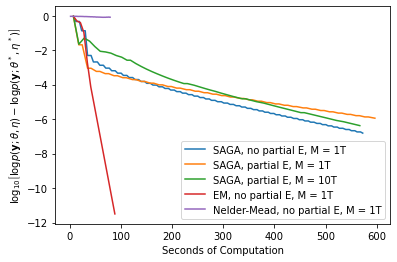

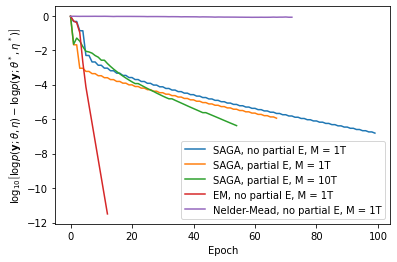

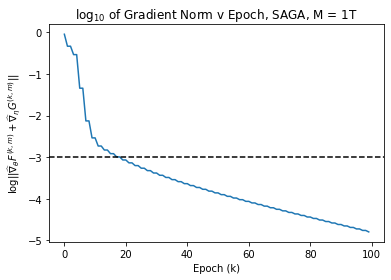

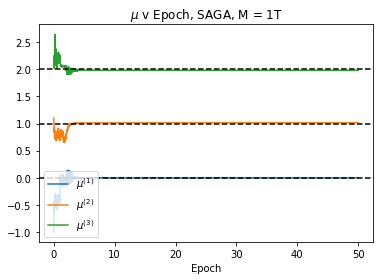

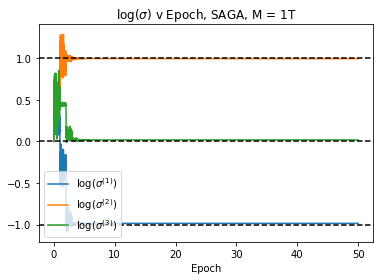

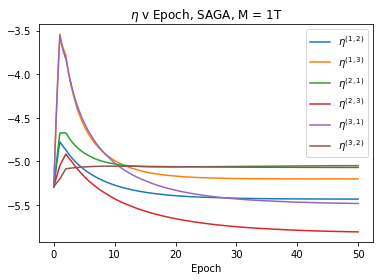

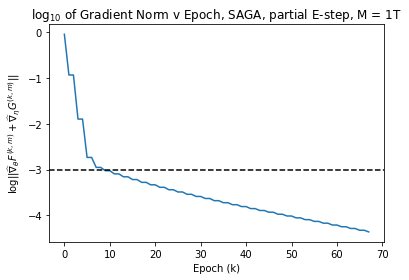

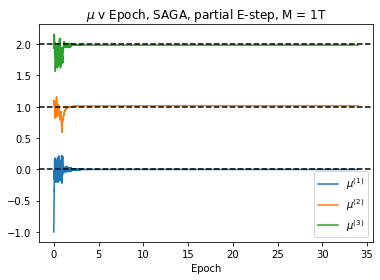

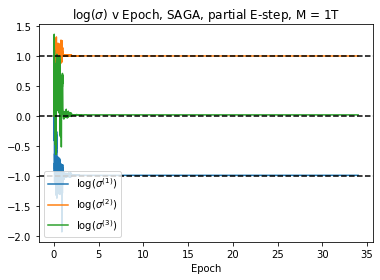

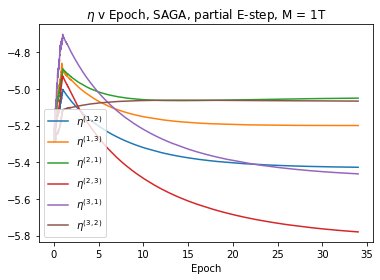

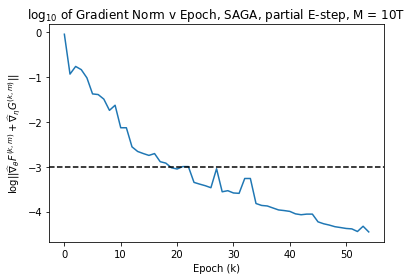

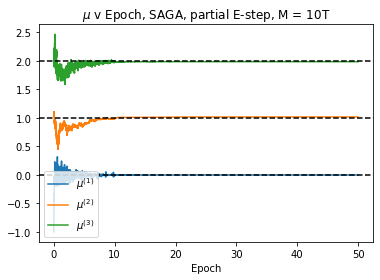

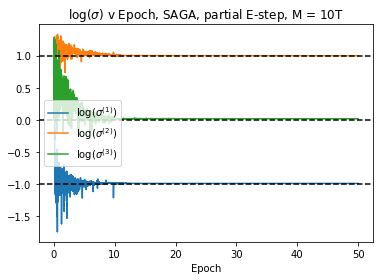

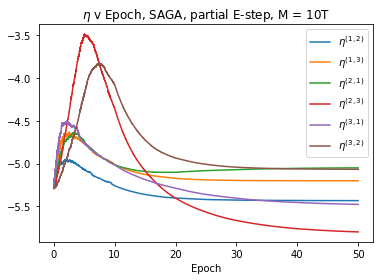

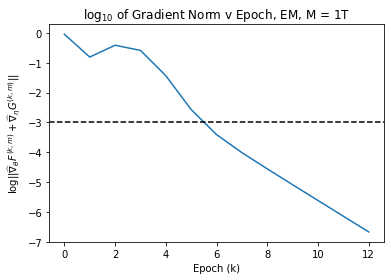

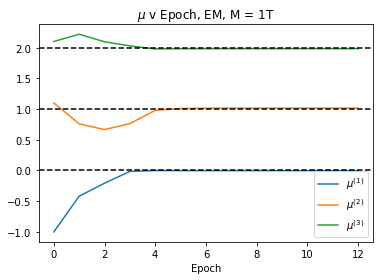

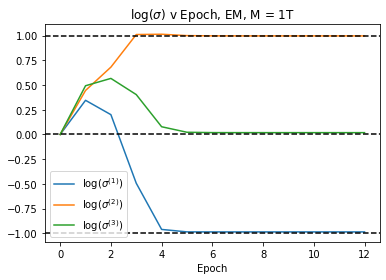

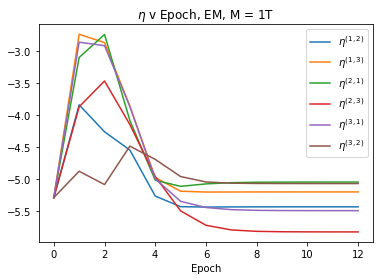

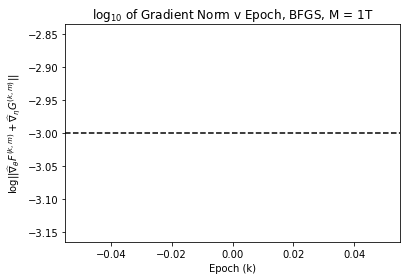

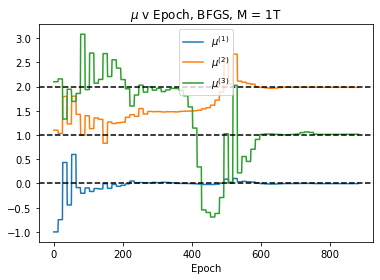

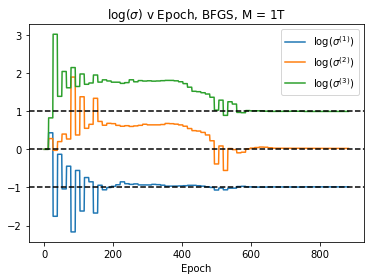

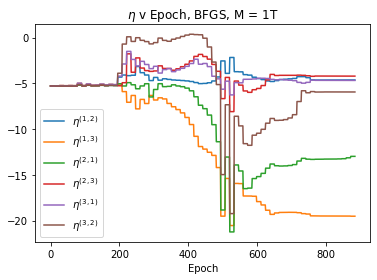

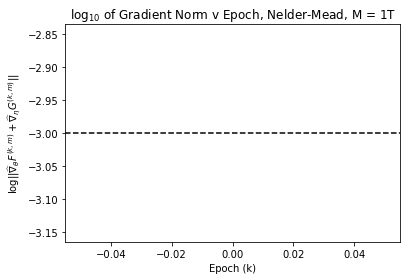

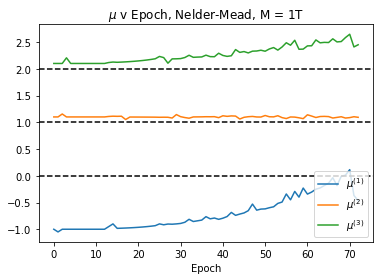

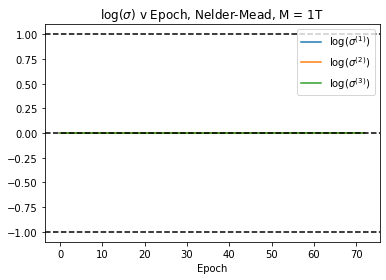

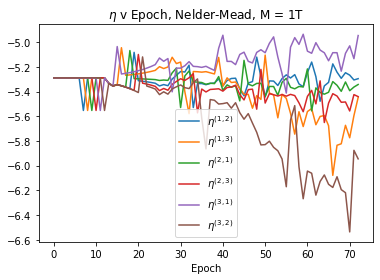

In [12]:
plot_ll(optims,x_time=True)
plot_ll(optims,x_time=False)

for method in methods:#["EM","SGD","SAG","SVRG","SAGA"]:
    for partial_E in [0,0.5,1]:
        PE = (partial_E == 0.5) or (partial_E == 1)
        M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
        if (method,partial_E) in optims:
            plot_results(optims[(method,partial_E)],optim_ll,method,PE,M)